In [1]:
## 모듈 로딩
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch import optim
from torchmetrics.classification import *
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
%matplotlib inline

이름 변경

0은 충치없음 1은 충치있음

In [2]:
img_dir = './data/0_and_1'

In [3]:
preprocessing = transforms.Compose([
transforms.Resize((512,512)),
transforms.ToTensor()])


In [4]:
imgDS = datasets.ImageFolder(root=img_dir, transform=preprocessing)

In [5]:
imgDS.class_to_idx

{'0': 0, '1': 1}

In [6]:
# train, val, test 분할 비율 정의 (예: 70%, 15%, 15%)
train_size = int(0.7 * len(imgDS))
val_size = int(0.15 * len(imgDS))
test_size = len(imgDS) - train_size - val_size

# 데이터 분할
train_data, val_data, test_data = random_split(imgDS, [train_size, val_size, test_size])

# DataLoader 생성 (batch_size는 필요에 따라 설정)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
print(len(train_data),len(val_data),len(test_data))

140 30 30


----

In [8]:
from torchvision import models
from torchvision.models import VGG16_Weights
from torchinfo import summary

# 사전 학습된 모델 로딩
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

In [9]:
summary(model, input_size=[1, 3, 512, 512])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 64, 512, 512]         1,792
│    └─ReLU: 2-2                         [1, 64, 512, 512]         --
│    └─Conv2d: 2-3                       [1, 64, 512, 512]         36,928
│    └─ReLU: 2-4                         [1, 64, 512, 512]         --
│    └─MaxPool2d: 2-5                    [1, 64, 256, 256]         --
│    └─Conv2d: 2-6                       [1, 128, 256, 256]        73,856
│    └─ReLU: 2-7                         [1, 128, 256, 256]        --
│    └─Conv2d: 2-8                       [1, 128, 256, 256]        147,584
│    └─ReLU: 2-9                         [1, 128, 256, 256]        --
│    └─MaxPool2d: 2-10                   [1, 128, 128, 128]        --
│    └─Conv2d: 2-11                      [1, 256, 128, 128]        29

In [10]:
class CustomVgg16Model(nn.Module):
    def __init__(self):
        super(CustomVgg16Model, self).__init__()    
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = model.classifier
        self.custom_layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x):
        y = self.features(x)
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        y = F.sigmoid(self.custom_layer(y))
        
        return y

In [11]:
model = CustomVgg16Model()
print(model)
summary(model)

CustomVgg16Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

Layer (type:depth-idx)                   Param #
CustomVgg16Model                         --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [12]:
# 사전학습된 모델의 파라미터 비활성화 설정
for named, params in model.named_parameters():
    print(f"[{named}] - {params.shape}")
    # 역전파시 업데이트가 되지 않도록 설정
    params.requires_grad = False

[features.0.weight] - torch.Size([64, 3, 3, 3])
[features.0.bias] - torch.Size([64])
[features.2.weight] - torch.Size([64, 64, 3, 3])
[features.2.bias] - torch.Size([64])
[features.5.weight] - torch.Size([128, 64, 3, 3])
[features.5.bias] - torch.Size([128])
[features.7.weight] - torch.Size([128, 128, 3, 3])
[features.7.bias] - torch.Size([128])
[features.10.weight] - torch.Size([256, 128, 3, 3])
[features.10.bias] - torch.Size([256])
[features.12.weight] - torch.Size([256, 256, 3, 3])
[features.12.bias] - torch.Size([256])
[features.14.weight] - torch.Size([256, 256, 3, 3])
[features.14.bias] - torch.Size([256])
[features.17.weight] - torch.Size([512, 256, 3, 3])
[features.17.bias] - torch.Size([512])
[features.19.weight] - torch.Size([512, 512, 3, 3])
[features.19.bias] - torch.Size([512])
[features.21.weight] - torch.Size([512, 512, 3, 3])
[features.21.bias] - torch.Size([512])
[features.24.weight] - torch.Size([512, 512, 3, 3])
[features.24.bias] - torch.Size([512])
[features.26.we

In [13]:
# 모델의 FC 파라미터 활성화 설정
for named, params in model.custom_layer.named_parameters():
    print(f"[{named}] - {params.shape}")
    params.requires_grad = True

[1.weight] - torch.Size([500, 1000])
[1.bias] - torch.Size([500])
[3.weight] - torch.Size([50, 500])
[3.bias] - torch.Size([50])
[5.weight] - torch.Size([1, 50])
[5.bias] - torch.Size([1])


In [14]:
## 학습 진행 관련 설정
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
epochs = 100
BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001
optimizer = optim.Adam(model.parameters(), lr=LR)
crossLoss = nn.BCELoss()
# scheduler = ReduceLROnPlateau(optimizer, patience=10, mode='max')
criterion = nn.BCEWithLogitsLoss().to(device)
train_batch_cnt = len(train_loader) / BATCH_SIZE
val_batch_cnt = len(val_loader) / BATCH_SIZE


In [15]:
def train(model, dataset, criterion, optimizer, device, interval):
    model.train()
    losses = list()
    corrects = 0
    total = 0

    for step, (images, labels) in enumerate(dataset):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
   
        pre_y = model(images)
    
        loss = criterion(pre_y, labels)
        losses.append(loss.item())

        yhat = torch.sigmoid(pre_y)>.5
        corrects += torch.eq(yhat, labels).sum().item()
        total += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}, Train Accuracy: {corrects / total:.4f}')


In [16]:
def Val(model, dataset, criterion, device, epoch):
    model.eval()
    losses_V= list()
    corrects_V = list()

    for images, labels in dataset:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        pre_v = model(images)
        loss = criterion(pre_v, labels)
        losses_V.append(loss.item())
        
        yhat = torch.sigmoid(pre_v)>.5
        corrects_V.extend(torch.eq(yhat, labels).cpu().tolist())
        
    val_loss = np.mean(losses_V)
    val_accuracy = np.mean(corrects_V)

    print(f'{epoch} Val Loss : {val_loss:.4f}, Val Accuracy : {val_accuracy:.4f}')

    return val_loss, val_accuracy 

In [17]:
interval = 10
BEST_HISTORY = 0
all_score = []
all_loss = []
stop_num = 0

for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, device, interval)
    loss, score = Val(model, train_loader, criterion, device, epoch)

    all_loss.append(loss)
    all_score.append(score)

    # 모델 폴더가 없다면 생성
    if not os.path.exists('model/'):
        os.mkdir('model/')
    
    if (score != 0) and (BEST_HISTORY < score):
        BEST_HISTORY = score
        torch.save(model, f'model/best_model{epoch}.pth')

    if BEST_HISTORY >= score:
        stop_num += 1
        if stop_num > 10 :
            break

Train Loss 0 : 0.7361971735954285, Train Accuracy: 0.4688
0 Val Loss : 0.5921, Val Accuracy : 0.5357
Train Loss 0 : 0.5415087938308716, Train Accuracy: 0.6875
1 Val Loss : 0.5216, Val Accuracy : 0.5357
Train Loss 0 : 0.5575911402702332, Train Accuracy: 0.4375
2 Val Loss : 0.4993, Val Accuracy : 0.5357
Train Loss 0 : 0.49721765518188477, Train Accuracy: 0.5312
3 Val Loss : 0.4870, Val Accuracy : 0.5357
Train Loss 0 : 0.4725596010684967, Train Accuracy: 0.5938
4 Val Loss : 0.5128, Val Accuracy : 0.5357
Train Loss 0 : 0.5211254358291626, Train Accuracy: 0.5312
5 Val Loss : 0.5009, Val Accuracy : 0.5429
Train Loss 0 : 0.4449757933616638, Train Accuracy: 0.7188
6 Val Loss : 0.4886, Val Accuracy : 0.5357
Train Loss 0 : 0.47077617049217224, Train Accuracy: 0.5938
7 Val Loss : 0.4879, Val Accuracy : 0.5357
Train Loss 0 : 0.5439552664756775, Train Accuracy: 0.4375
8 Val Loss : 0.4848, Val Accuracy : 0.5786
Train Loss 0 : 0.5131014585494995, Train Accuracy: 0.6250
9 Val Loss : 0.4851, Val Accura

In [18]:
def Test(model, dataset, criterion, device):
    model.eval()
    losses_t= list()
    corrects_t = list()

    for images, labels in dataset:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        pre_t = model(images)
        loss = criterion(pre_t, labels)
        losses_t.append(loss.item())
        
        yhat = torch.sigmoid(pre_t)>.5
        corrects_t.extend(torch.eq(yhat, labels).cpu().tolist())
        
    print(f'Val Loss : {np.mean(losses_t)}, Val Accuracy : {np.mean(corrects_t)}')

    return  print(max(corrects_t))

ValueError: x and y must have same first dimension, but have shapes (100,) and (11,)

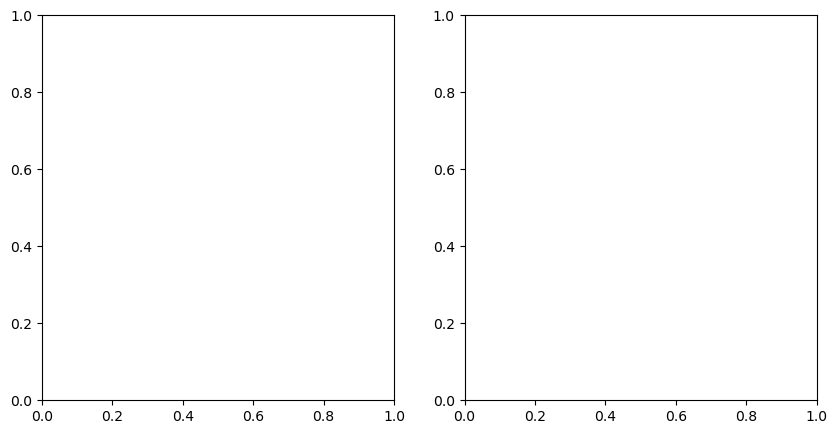

In [19]:
fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True )
axes[0].plot(range(1, epochs+1), all_loss, label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, epochs+1), all_score, label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("score")
axes[1].set_title("score")
plt.tight_layout()
plt.show()